In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt

# visualize data

In [2]:
mat=sio.loadmat('./data/ex7data2.mat')
data2 = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


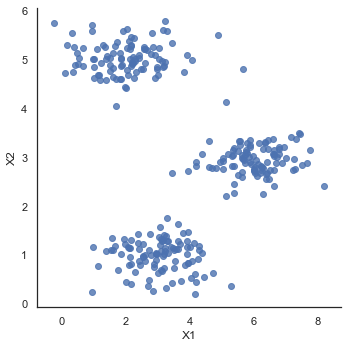

In [3]:
sns.set(context='notebook', style='white')
sns.lmplot('X1', 'X2', data=data2, fit_reg=False)
plt.show()

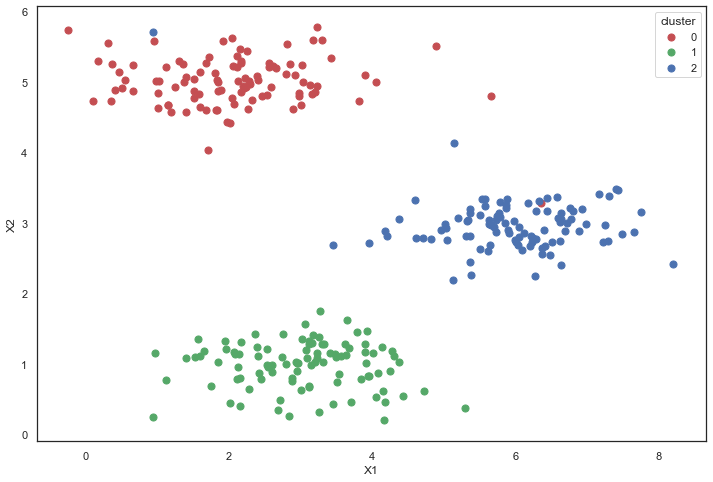

In [4]:
data2_1 = data2[:100]
data2_2 = data2[101:200]
data2_3 = data2[201:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(data2_1['X1'], data2_1['X2'], s=50, color='r', edgecolors='r', label='0')
ax.scatter(data2_2['X1'], data2_2['X2'], s=50, color='g', edgecolors='g', label='1')
ax.scatter(data2_3['X1'], data2_3['X2'], s=50, color='b', edgecolors='b', label='2')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend(loc='best', title='cluster')
plt.show()

# 2D Kmeans

In [5]:
def random_init(data, k):
    return data.sample(k).values

In [6]:
def combine_data_C(data, C):
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c

In [7]:
def nearst_cluster(x, centroids):
    distances = np.apply_along_axis(func1d=np.linalg.norm, axis=1, arr=centroids - x)
    return np.argmin(distances)

In [8]:
def assign_cluster(data, centroids):
    return np.apply_along_axis(lambda x: nearst_cluster(x, centroids), 
                              axis=1, arr=data.values)

In [9]:
def new_centroids(data, C):
    data_with_c = combine_data_C(data, C)
    return data_with_c.groupby('C', as_index=False).mean().sort_values(by='C').drop('C', axis=1).values

In [10]:
def cost(data, centroids, C):
    m = data.shape[0]
    data_belong_C = centroids[C]
    distances = np.apply_along_axis(func1d=np.linalg.norm, axis=1, 
                                    arr=data.values-data_belong_C)
    return distances.sum()/m

In [11]:
def k_means_iter(data, k, epoch=100, tol=0.0001):
    centroids=random_init(data, k)
    cost_epoch = []
    
    for i in range(epoch):
        C = assign_cluster(data, centroids)
        centroids = new_centroids(data, C)
        cost_epoch.append(cost(data, centroids, C))
        
        if i>0 and np.abs(cost_epoch[-1] - cost_epoch[-2]) / cost_epoch[-1] < tol:
            break;
            
        return C, centroids, cost_epoch[-1]

In [12]:
def k_means(data, k, epoch=100, n_init=10):
    tries = np.array([k_means_iter(data, k, epoch) for _ in range(n_init)])
    least_cost_idx = np.argmin(tries[:, -1])
    
    return tries[least_cost_idx]

In [13]:
init_centroids = random_init(data2, 3)
init_centroids

array([[2.15520661, 0.80696562],
       [0.10511804, 4.72916344],
       [3.27844295, 1.75043926]])

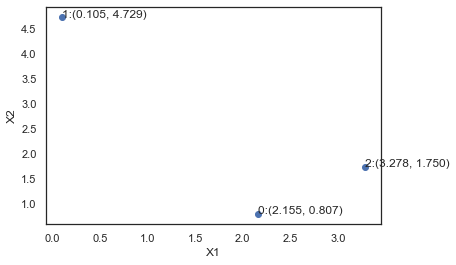

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x=init_centroids[:, 0], y=init_centroids[:, 1])
ax.set_xlabel('X1')
ax.set_ylabel('X2')

for i, node in enumerate(init_centroids):
    ax.annotate('{}:({:.3f}, {:.3f})'.format(i, node[0], node[1]), node)
plt.show()    

In [15]:
final_C, final_centroids, least_cost = k_means(data2, 3, n_init=100)
data_with_C = combine_data_C(data2, final_C)

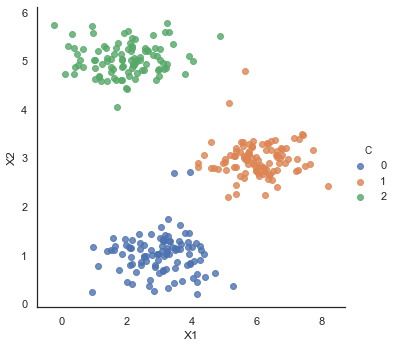

In [16]:
sns.lmplot('X1', 'X2', hue='C', data=data_with_C, fit_reg=False)
plt.show()

In [17]:
cost(data2, final_centroids, final_C), least_cost

(0.7939723095300589, 0.7939723095300589)

# Sklearn Kmeans

In [18]:
from sklearn.cluster import KMeans
sk_kmeans = KMeans(n_clusters=3)
sk_kmeans.fit(data2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

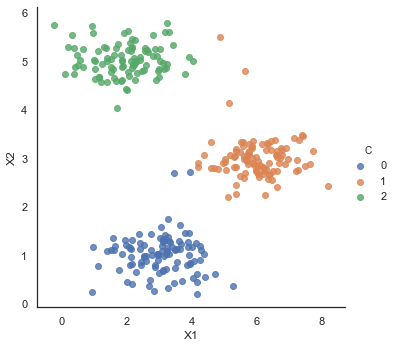

In [19]:
sk_C = sk_kmeans.predict(data2)
data_with_C = combine_data_C(data2, sk_C)
sns.lmplot('X1', 'X2', hue='C', data=data_with_C, fit_reg=False)
plt.show()

# Image Compression

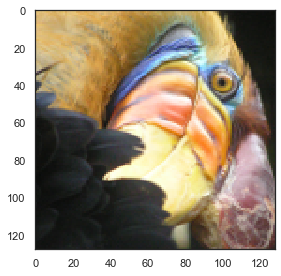

In [20]:
from skimage import io

pic = io.imread('./data/bird_small.png') / 255
io.imshow(pic)

In [21]:
pic.shape

(128, 128, 3)

In [22]:
data = pic.reshape(128*128, 3)
data.shape

(16384, 3)

## use manual kmeans

In [23]:
C, centroids, cost_ = k_means(pd.DataFrame(data), 16, epoch=10, n_init=3)
cost_

0.08772854426935271

In [24]:
compressed_pic = centroids[C].reshape((128,128,3))

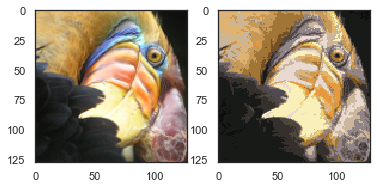

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

## use Sklearn.cluster.KMeans

In [26]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=16, n_init=100, n_jobs=-1)
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [27]:
centroids = model.cluster_centers_
C = model.predict(data)

centroids.shape, C.shape

((16, 3), (16384,))

In [28]:
compressed_pic = centroids[C].reshape((128,128,3))

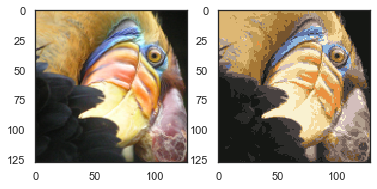

In [29]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()